In [1]:
import xarray as xr
from xclim import sdba
from xclim.core.calendar import convert_calendar
import xclim.indices as xci
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import ec3
import gcsfs
import zarr

# lat and lon coordinates for Edmonton
lat_edm = 53.5
lon_edm = -113.5

# time periods for historical and future periods
years_hist = range(1980, 2011) # remember that range(start, end) is not inclusive of `end`
years_future = range(2070, 2101)

# url for the CSV file that contains the data catalog
url_gcsfs_catalog = 'https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv'

/Users/mikemorris/opt/anaconda3/envs/UTCDW/lib/python3.9/site-packages/xclim/indices/fire/_cffwis.py:218: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _day_length(lat: int | float, mth: int):  # pragma: no cover
/Users/mikemorris/opt/anaconda3/envs/UTCDW/lib/python3.9/site-packages/xclim/indices/fire/_cffwis.py:238: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for detail

In [2]:
# search for stations near our desired location
find_stn_results = ec3.find_station(target = (lat_edm, lon_edm), 
                                    period = range(1980, 2011),
                                    type = 'daily',
                                    dist = range(25),
                                    detect_recodes = True)


/Users/mikemorris/opt/anaconda3/envs/UTCDW/lib/python3.9/site-packages/ec3.py:105: UserWarning: Cannot find the station inventory in the current working directory.
  warnings.warn("Cannot find the station inventory in the current working directory.")


Note: In addition to the stations found, the following combinations may provide sufficient baseline data.


>> Combination 1 at coordinates 53.57 -113.52 

Station 1864 : EDMONTON CALDER (1975-1977)
Station 1867 : EDMONTON CITY CENTRE A (1937-2005)
Station 27214 : EDMONTON BLATCHFORD (1996-2023)
Station 31427 : EDMONTON CITY CENTRE AWOS (2005-2015)




In [3]:
find_stn_results

,Name,Province,Climate ID,Station ID,WMO ID,TC ID,Latitude (Decimal Degrees),Longitude (Decimal Degrees),Latitude,Longitude,Elevation (m),First Year,Last Year,DLY First Year,DLY Last Year,Dist
2429,EDMONTON WOODBEND,ALBERTA,3012230,1872,NaN,NaN,53.42,-113.75,532500000.0,-1.134500e+09,670.6,1973,2015,1973.0,2015.0,18.841757933518178 km
2416,EDMONTON INT'L A,ALBERTA,3012205,1865,71123.0,YEG,53.32,-113.58,531900000.0,-1.133500e+09,723.3,1959,2012,1959.0,2012.0,20.72726507003484 km


In [4]:
def download_station_data(stn_id, years = range(1992, 2022)):
    """
    Download ECCC observational data at the weather station identified with stn_id,
    re-name the columns to more useful names. Optional: select specific years of data,
    but by default, download all data from 1990--2020.
    """
    # download the data
    df = ec3.get_data(stn_id, years = years, progress = False)
    
    # dictionary mapping original column names to new ones
    column_name_dict = {'Date/Time': 'time', 
                        'Mean Temp (°C)': 'tas',
                        'Latitude (y)': 'lat',
                        'Longitude (x)': 'lon',
                        'Station Name': 'Name'}
    
    df = df.rename(columns = column_name_dict)
    
    # select only the variables we re-named - you can comment this out if you want to keep all variables
    df = df[list(column_name_dict.values())]
    
    # set the "time" column as an index column and convert it from strings to Datetime objects to make
    # selecting times easier
    df['time'] = pd.to_datetime(df['time'])
    df = df.set_index("time")
    
    # sort the data in proper chronological order
    df = df.sort_index()
    
    df = df.dropna()
    
    return df

In [5]:
# download the station data
stn_id_list = [1867, 31427]
df_list = []
for stn_id in stn_id_list:
    df = download_station_data(stn_id, years = years_hist)
    # print first and last timestep so we can check if there is any time overlap
    # between the two records
    print(stn_id, f"start: {df.index.values.min()}", f"end: {df.index.values.max()}")
    df_list.append(df)


1867 start: 1980-01-01T00:00:00.000000000 end: 2005-01-20T00:00:00.000000000


31427 start: 2005-01-21T00:00:00.000000000 end: 2010-12-31T00:00:00.000000000


In [6]:
# the above output shows no overlap in time between the two stations, so we can safely
# concatenate them without dropping any data from one or the other
stn_df = pd.concat(df_list, axis = 0)

# now convert it to xarray format for easier use with the model data and xclim

# drop lat and lon variables, since we want these to be coordinates in the xr.Dataset
stn_lon = stn_df.lon.values[0] + 360 # convert lon to same convention as model data
stn_lat = stn_df.lat.values[0] 

stn_df = stn_df.drop(['lat', 'lon'], axis = 1)

stn_ds = xr.Dataset.from_dataframe(stn_df)
stn_ds = stn_ds.assign_coords(lat = stn_lat, lon = stn_lon)
stn_ds

<xarray.Dataset>
Dimensions:  (time: 11214)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2010-12-31
    lat      float64 53.57
    lon      float64 246.5
Data variables:
    tas      (time) float64 -9.4 -5.8 -10.3 -11.8 ... -11.0 -17.6 -18.0 -19.0
    Name     (time) object 'EDMONTON CITY CENTRE A' ... 'EDMONTON CITY CENTRE...

In [7]:
# open the Google Cloud model data catalog with pandas
df_catalog = pd.read_csv(url_gcsfs_catalog)

# search for our selected model, both historical and SSP3-7.0 scenarios
search_string = "table_id == 'day' & source_id == 'CESM2' & variable_id == 'tas'" # continue on the next line
search_string += " & experiment_id == ['historical', 'ssp370']"
df_search = df_catalog.query(search_string)

# print a summary of the resulting dataframe, click to reveal
df_search 


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
58919,CMIP,NCAR,CESM2,historical,r1i1p1f1,day,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1...,NaN,20190308
61527,CMIP,NCAR,CESM2,historical,r5i1p1f1,day,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r5...,NaN,20190308
61604,CMIP,NCAR,CESM2,historical,r4i1p1f1,day,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r4...,NaN,20190308
61627,CMIP,NCAR,CESM2,historical,r3i1p1f1,day,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r3...,NaN,20190308
62145,CMIP,NCAR,CESM2,historical,r6i1p1f1,day,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r6...,NaN,20190308
63061,CMIP,NCAR,CESM2,historical,r2i1p1f1,day,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r2...,NaN,20190308
64025,CMIP,NCAR,CESM2,historical,r7i1p1f1,day,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r7...,NaN,20190311
65331,CMIP,NCAR,CESM2,historical,r9i1p1f1,day,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r9...,NaN,20190311
65878,CMIP,NCAR,CESM2,historical,r8i1p1f1,day,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r8...,NaN,20190311
66385,CMIP,NCAR,CESM2,historical,r10i1p1f1,day,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1...,NaN,20190313


In [8]:
# filter the search results further for the ensemble member we want to use
df_search_r10i1p1f1 = df_search.query("member_id == 'r10i1p1f1'")

# authenticate access to Google Cloud
gcs = gcsfs.GCSFileSystem(token='anon')

# get the URLs for each dataset and turn into zarr store mappers
url_hist = df_search_r10i1p1f1[df_search_r10i1p1f1.experiment_id == 'historical'].zstore.values[0]
mapper_hist = gcs.get_mapper(url_hist)
url_ssp3 = df_search_r10i1p1f1[df_search_r10i1p1f1.experiment_id == 'ssp370'].zstore.values[0]
mapper_ssp3 = gcs.get_mapper(url_ssp3)


In [9]:
# download the datasets and interpolate data to the station coordinates

# historical
ds_hist_raw = xr.open_zarr(mapper_hist, consolidated = True)
tas_hist_raw = ds_hist_raw.tas.interp(lat = stn_lat, lon = stn_lon) - 273.15 # also convert to C

# future
ds_ssp3_raw = xr.open_zarr(mapper_ssp3, consolidated = True)
tas_ssp3_raw = ds_ssp3_raw.tas.interp(lat = stn_lat, lon = stn_lon) - 273.15 

# select time periods
tas_hist_raw = tas_hist_raw.sel(time = tas_hist_raw.time.dt.year.isin(years_hist))
tas_ssp3_raw = tas_ssp3_raw.sel(time = tas_ssp3_raw.time.dt.year.isin(years_future))

In [10]:
# calculate daily climatologies

# station
tas_dailyclim_obs = stn_ds.tas.groupby('time.dayofyear').mean('time').compute()
tas_dailyclim_std_obs = stn_ds.tas.groupby('time.dayofyear').std('time').compute()

# raw historical
tas_dailyclim_hist_raw = tas_hist_raw.groupby('time.dayofyear').mean('time').compute()
tas_dailyclim_std_hist_raw = tas_hist_raw.groupby('time.dayofyear').std('time').compute()


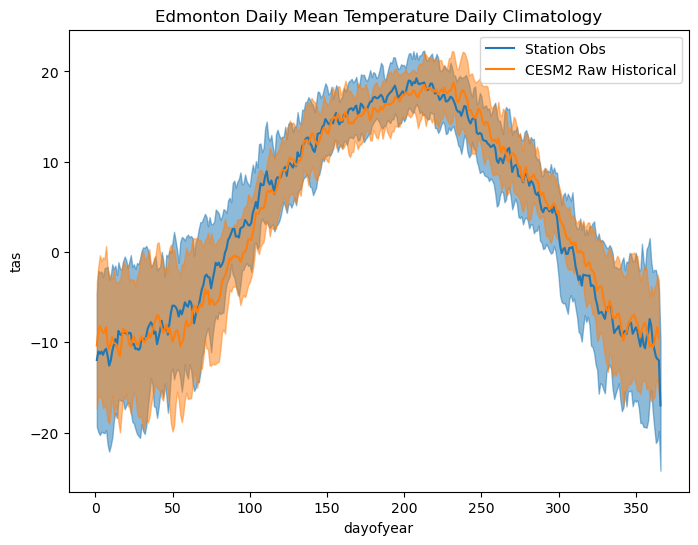

In [11]:
# plot daily climatologies for historical simulation and obs
fig, ax = plt.subplots(figsize = (8,6))

# daily climatologies as 1D curves
tas_dailyclim_obs.plot.line(ax = ax, label = "Station Obs", color = 'tab:blue')
tas_dailyclim_hist_raw.plot.line(ax = ax, label = "CESM2 Raw Historical", color = 'tab:orange')

# 1 sigma shading

# obs
ax.fill_between(tas_dailyclim_obs.dayofyear,
                tas_dailyclim_obs - tas_dailyclim_std_obs, 
                tas_dailyclim_obs + tas_dailyclim_std_obs,
                alpha = 0.5, color = 'tab:blue')
# raw historical
ax.fill_between(tas_dailyclim_hist_raw.dayofyear, 
                tas_dailyclim_hist_raw - tas_dailyclim_std_hist_raw, 
                tas_dailyclim_hist_raw  + tas_dailyclim_std_hist_raw,
                alpha = 0.5, color = 'tab:orange')

ax.set_title("Edmonton Daily Mean Temperature Daily Climatology")
ax.legend()
plt.show()

In [12]:
# calculate station daily climatology again after converting its calendar to match the model
stn_ds_noleap = convert_calendar(stn_ds, 'noleap')
tas_obs_noleap = stn_ds_noleap.tas

tas_dailyclim_obs = tas_obs_noleap.groupby('time.dayofyear').mean('time').compute()
tas_dailyclim_std_obs = tas_obs_noleap.groupby('time.dayofyear').std('time').compute()

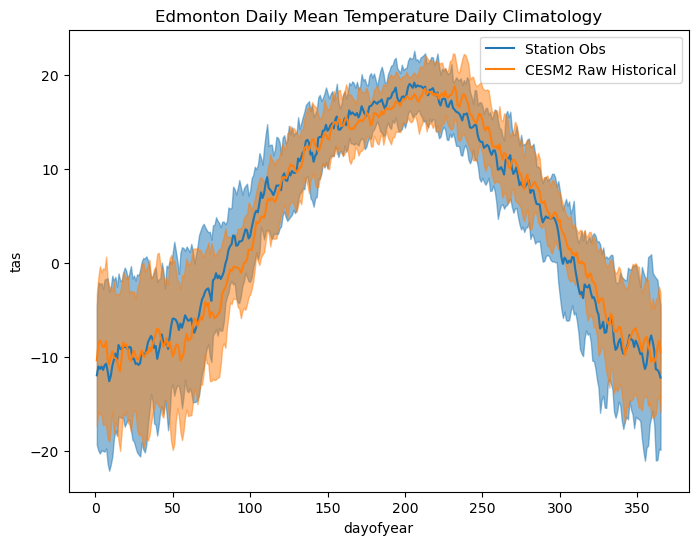

In [13]:
# plot daily climatologies for historical simulation and obs
fig, ax = plt.subplots(figsize = (8,6))

# daily climatologies as 1D curves
tas_dailyclim_obs.plot.line(ax = ax, label = "Station Obs", color = 'tab:blue')
tas_dailyclim_hist_raw.plot.line(ax = ax, label = "CESM2 Raw Historical", color = 'tab:orange')

# 1 sigma shading

# obs
ax.fill_between(tas_dailyclim_obs.dayofyear,
                tas_dailyclim_obs - tas_dailyclim_std_obs, 
                tas_dailyclim_obs + tas_dailyclim_std_obs,
                alpha = 0.5, color = 'tab:blue')
# raw historical
ax.fill_between(tas_dailyclim_hist_raw.dayofyear, 
                tas_dailyclim_hist_raw - tas_dailyclim_std_hist_raw, 
                tas_dailyclim_hist_raw  + tas_dailyclim_std_hist_raw,
                alpha = 0.5, color = 'tab:orange')

ax.set_title("Edmonton Daily Mean Temperature Daily Climatology")
ax.legend()
plt.show()

In [14]:
# fit Kernel Density Estimator so we can plot a smooth distribution
kde_hist_raw = stats.gaussian_kde(tas_hist_raw.values)
kde_obs = stats.gaussian_kde(tas_obs_noleap.values) 

# means and stdev ratios
tas_hist_raw_mean = tas_hist_raw.mean('time').compute()
tas_obs_mean = tas_obs_noleap.mean('time').compute()

# stdevs for each dataset
tas_hist_raw_stdev = tas_hist_raw.std('time').compute()
tas_obs_stdev = tas_obs_noleap.std('time').compute()


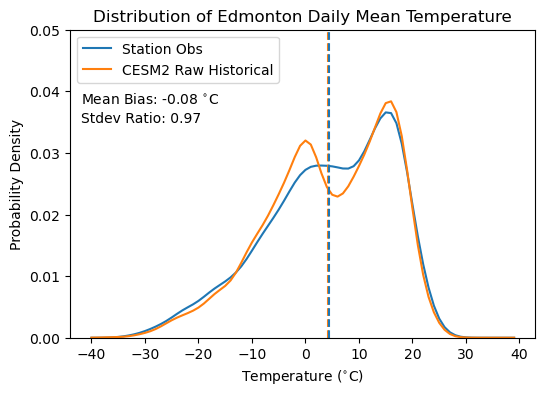

In [15]:
# plot the PDFs smoothed by KDE
temperatures = np.arange(-40, 40)
plt.figure(figsize = (6,4))
plt.title("Distribution of Edmonton Daily Mean Temperature")
plt.plot(temperatures, kde_obs(temperatures), label = 'Station Obs', color = 'tab:blue')
plt.plot(temperatures, kde_hist_raw(temperatures), label = 'CESM2 Raw Historical', color = 'tab:orange')
plt.vlines([tas_hist_raw_mean, tas_obs_mean], 0, 1, colors = ['tab:orange', 'tab:blue'], linestyles = '--')
plt.ylim(0, 0.05)
plt.xlabel(r"Temperature ($^{\circ}$C)")
plt.ylabel("Probability Density")
plt.legend(loc = 'upper left')

# annotate with mean bias and ratio of stdevs
plt.text(-42, 0.038, r'Mean Bias: %.2f $^{\circ}$C' % (tas_hist_raw_mean - tas_obs_mean))
plt.text(-42, 0.035, r'Stdev Ratio: %.2f' % (tas_hist_raw_stdev / tas_obs_stdev))

plt.show()

In [16]:
# add unit attributes to tas data for use with xclim routines
tas_obs_noleap.attrs['units'] = 'degC'
tas_hist_raw.attrs['units'] = 'degC'

# calculate CDDs
cdd_obs = xci.cooling_degree_days(tas_obs_noleap).compute()
cdd_hist_raw = xci.cooling_degree_days(tas_hist_raw).compute()

# long-term means for the historical period
cdd_obs_ltm = cdd_obs.mean('time').compute()
cdd_hist_raw_ltm = cdd_hist_raw.mean('time').compute()

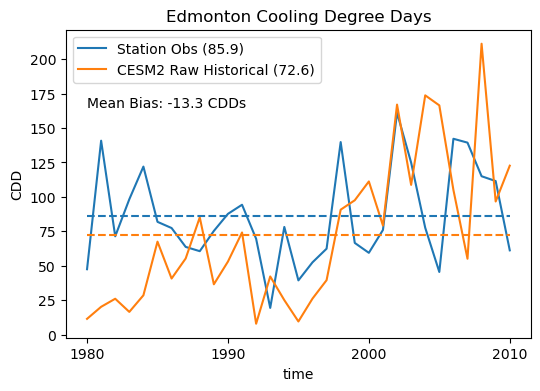

In [17]:
# plot timeseries of CDDs for model historical and obs
fig, ax = plt.subplots(figsize = (6, 4))
cdd_obs.plot.line(label = "Station Obs (%.1f)" % cdd_obs_ltm.values, color = 'tab:blue')
cdd_hist_raw.plot.line(label = "CESM2 Raw Historical (%.1f)" % cdd_hist_raw_ltm.values, color = 'tab:orange')

# plot long-term means
ax.hlines([cdd_obs_ltm.values, cdd_hist_raw_ltm.values], 
          cdd_obs.time.min().values, cdd_obs.time.max().values, 
          colors = ['tab:blue', 'tab:orange'], linestyles = '--')

ax.set(title = "Edmonton Cooling Degree Days", ylabel = "CDD")
ax.legend()

# show the mean bias on the plot
ax.text(cdd_obs.time[0].values, 165, "Mean Bias: %.1f CDDs" % (cdd_hist_raw_ltm.values - cdd_obs_ltm.values))
plt.show()

In [18]:
# daily climatology for raw SSP3-7.0
tas_dailyclim_ssp3_raw = tas_ssp3_raw.groupby('time.dayofyear').mean('time').compute()
tas_dailyclim_std_ssp3_raw = tas_ssp3_raw.groupby('time.dayofyear').std('time').compute()

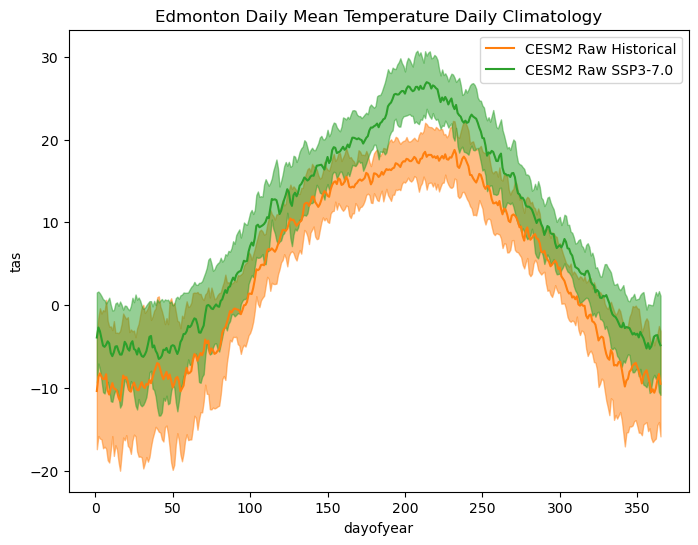

In [19]:
# plot daily climatologies for both model simulations
fig, ax = plt.subplots(figsize = (8,6))

# daily climatologies as 1D curves
tas_dailyclim_hist_raw.plot.line(ax = ax, label = "CESM2 Raw Historical", color = 'tab:orange')
tas_dailyclim_ssp3_raw.plot.line(ax = ax, label = "CESM2 Raw SSP3-7.0", color = 'tab:green')

# 1 sigma shading
# raw historical
ax.fill_between(tas_dailyclim_hist_raw.dayofyear, 
                tas_dailyclim_hist_raw - tas_dailyclim_std_hist_raw, 
                tas_dailyclim_hist_raw  + tas_dailyclim_std_hist_raw,
                alpha = 0.5, color = 'tab:orange')
# raw SSP3-7.0
ax.fill_between(tas_dailyclim_ssp3_raw.dayofyear, 
                tas_dailyclim_ssp3_raw - tas_dailyclim_std_ssp3_raw,
                tas_dailyclim_ssp3_raw + tas_dailyclim_std_ssp3_raw,
                alpha = 0.5, color = 'tab:green')

ax.set_title("Edmonton Daily Mean Temperature Daily Climatology")
ax.legend()
plt.show()

In [20]:
# calculate mean and stdev for future
tas_ssp3_raw_mean = tas_ssp3_raw.mean('time')
tas_ssp3_raw_stdev = tas_ssp3_raw.std('time')

In [21]:
# calculate effective sample size for historical and future periods
def effective_sample_size(data):
    ntime = len(data.time)
    # times not including the final timestep
    times = data.time.isel(time = slice(0, ntime - 1))
    # data not including the first timestep
    data_lag = data.isel(time = slice(1, ntime))
    # match up time values, otherwise the xr.corr function won't return the correct output
    data_lag = data_lag.assign_coords(time = times)
    
    # calculate correlation
    autocor = xr.corr(data.sel(time = times),
                      data_lag,
                      dim = 'time')
    
    neff = ntime * (1 - autocor) / (1 + autocor)
    
    return neff

neff_hist_raw = effective_sample_size(tas_hist_raw)
neff_ssp3_raw = effective_sample_size(tas_ssp3_raw)

In [22]:
# perform two_sample t-test to see if future temperatures are higher than past
tstat, pval_neff = stats.ttest_ind_from_stats(tas_hist_raw_mean,
                                              tas_hist_raw_stdev,
                                              neff_hist_raw, # effective sample size 
                                              tas_ssp3_raw_mean, 
                                              tas_ssp3_raw_stdev, 
                                              neff_ssp3_raw,
                                              equal_var = False,
                                              alternative = 'less') 
# alt hypothesis is that the first dataset (historical) has a lower mean than the second dataset (future)

print("p-value for t-test: %.4f" % pval_neff)

p-value for t-test: 0.0001


In [23]:
# add unit attributes to tas data for use with xclim routines
tas_ssp3_raw.attrs['units'] = 'degC'

# calculate CDDs
cdd_ssp3_raw = xci.cooling_degree_days(tas_ssp3_raw).compute()

# long-term means
cdd_ssp3_raw_ltm = cdd_ssp3_raw.mean('time').compute()

# stdevs for historical and ssp3
cdd_hist_raw_stdev = cdd_hist_raw.std('time').compute()
cdd_ssp3_raw_stdev = cdd_ssp3_raw.std('time').compute()

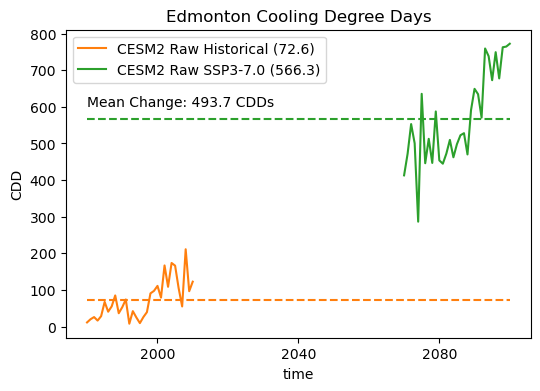

In [24]:
# plot timeseries of annual CDDs for the raw model data
fig, ax = plt.subplots(figsize = (6, 4))
cdd_hist_raw.plot.line(label = "CESM2 Raw Historical (%.1f)" % cdd_hist_raw_ltm.values, color = 'tab:orange')
cdd_ssp3_raw.plot.line(label = "CESM2 Raw SSP3-7.0 (%.1f)" % cdd_ssp3_raw_ltm.values, color = 'tab:green')

# plot long-term means
ax.hlines([cdd_ssp3_raw_ltm.values, cdd_hist_raw_ltm.values], 
          cdd_hist_raw.time.min().values, cdd_ssp3_raw.time.max().values, 
          colors = ['tab:green', 'tab:orange'], linestyles = '--')

ax.set(title = "Edmonton Cooling Degree Days", ylabel = "CDD")
ax.legend()

# show the mean change on the plot
ax.text(cdd_hist_raw.time[0].values, 600, "Mean Change: %.1f CDDs" % (cdd_ssp3_raw_ltm.values - cdd_hist_raw_ltm.values))
plt.show()

In [25]:
# perform two_sample t-test to see if the future period has more CDDs
tstat, pval_cdds = stats.ttest_ind_from_stats(cdd_hist_raw_ltm,
                                              cdd_hist_raw_stdev,
                                              len(cdd_hist_raw.time), # different years should be indep. of each other
                                              cdd_ssp3_raw_ltm,
                                              cdd_ssp3_raw_stdev,
                                              len(cdd_ssp3_raw.time),
                                              equal_var = False,
                                              alternative = 'less') 
# alt hypothesis is that the first dataset (historical) has a lower mean than the second dataset (future)

print("p-value for t-test: %.4f" % pval_cdds)

p-value for t-test: 0.0000


In [26]:
# do some data cleaning so xclim won't complain
tas_hist_raw = tas_hist_raw.chunk({'time': -1})
tas_ssp3_raw = tas_ssp3_raw.chunk({'time': -1})

In [27]:
# estimate the quantiles and calculate the adjustment factors
QDM_trained = sdba.adjustment.QuantileDeltaMapping.train(tas_obs_noleap,      # observational data
                                                         tas_hist_raw, # raw model historical data
                                             # number of quantiles to estimate (see documentation)
                                                         nquantiles = 50, 
             # additive adjustment, for interval variable (see documentation & Cannon et al. 2015)
                                                         kind = "+",
# separate adjustment applied to each month, to correct for bias in seasonal cycle (see documentation)
                                                         group = 'time.month' 
                                                        )

# apply the bias correction to the historical and SSP3-7.0 data
tas_hist_qdm = QDM_trained.adjust(tas_hist_raw, 
                    # how to interpolate between the nquantiles discrete quantile estimates                                  
                                 interp = 'linear')

tas_ssp3_qdm = QDM_trained.adjust(tas_ssp3_raw,                                 
                                  interp = 'linear')

In [28]:
# calculate the daily climatologies for the QDM data
tas_hist_qdm_dailyclim = tas_hist_qdm.groupby('time.dayofyear').mean('time').compute()
tas_hist_qdm_dailyclim_stdev = tas_hist_qdm.groupby('time.dayofyear').std('time').compute()

tas_ssp3_qdm_dailyclim = tas_ssp3_qdm.groupby('time.dayofyear').mean('time').compute()
tas_ssp3_qdm_dailyclim_stdev = tas_ssp3_qdm.groupby('time.dayofyear').std('time').compute()

In [29]:
# fit KDE curves for QDM data
kde_hist_qdm = stats.gaussian_kde(tas_hist_qdm.values)
kde_ssp3_qdm = stats.gaussian_kde(tas_ssp3_qdm.values)

# also fit KDE for raw SSP3-7.0 data
kde_ssp3_raw = stats.gaussian_kde(tas_ssp3_raw.values)

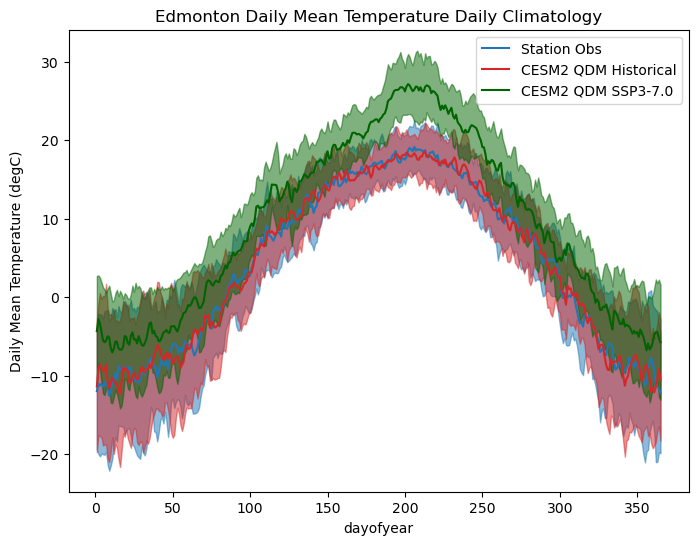

In [30]:
# plot daily climatologies
fig, ax = plt.subplots(figsize = (8,6))

# daily climatologies as 1D curves
tas_dailyclim_obs.plot.line(ax = ax, label = "Station Obs", color = 'tab:blue')
tas_hist_qdm_dailyclim.plot.line(ax = ax, label = "CESM2 QDM Historical", color = 'tab:red')
tas_ssp3_qdm_dailyclim.plot.line(ax = ax, label = "CESM2 QDM SSP3-7.0", color = 'darkgreen')


# 1 sigma shading
# obs
ax.fill_between(tas_dailyclim_obs.dayofyear,
                tas_dailyclim_obs - tas_dailyclim_std_obs, 
                tas_dailyclim_obs + tas_dailyclim_std_obs,
                alpha = 0.5, color = 'tab:blue')
# QDM historical
ax.fill_between(tas_hist_qdm_dailyclim.dayofyear, 
                tas_hist_qdm_dailyclim - tas_hist_qdm_dailyclim_stdev,
                tas_hist_qdm_dailyclim  + tas_hist_qdm_dailyclim_stdev,
                alpha = 0.5, color = 'tab:red')

# QDM SSP3-7.0
ax.fill_between(tas_ssp3_qdm_dailyclim.dayofyear, 
                tas_ssp3_qdm_dailyclim - tas_ssp3_qdm_dailyclim_stdev,
                tas_ssp3_qdm_dailyclim  + tas_ssp3_qdm_dailyclim_stdev,
                alpha = 0.5, color = 'darkgreen')


ax.set_title("Edmonton Daily Mean Temperature Daily Climatology")
ax.set_ylabel("Daily Mean Temperature (degC)")
ax.legend()
plt.show()

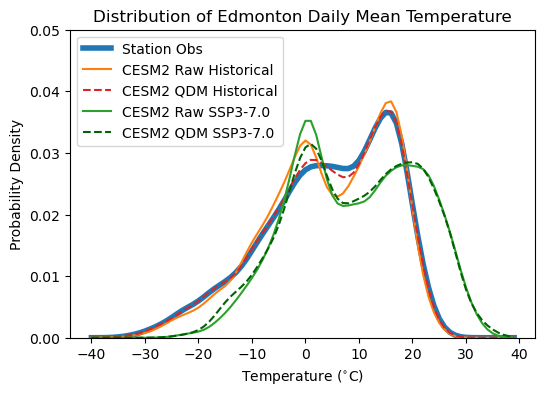

In [31]:
# plot KDEs
plt.figure(figsize = (6,4))
plt.title("Distribution of Edmonton Daily Mean Temperature")
plt.plot(temperatures, kde_obs(temperatures), label = 'Station Obs', color = 'tab:blue', linewidth = 4)

# historical
plt.plot(temperatures, kde_hist_raw(temperatures), label = 'CESM2 Raw Historical', color = 'tab:orange')
plt.plot(temperatures, kde_hist_qdm(temperatures), label = 'CESM2 QDM Historical',
         color = 'tab:red', linestyle = '--')

# SSP3-7.0
plt.plot(temperatures, kde_ssp3_raw(temperatures), label = 'CESM2 Raw SSP3-7.0', color = 'tab:green')
plt.plot(temperatures, kde_ssp3_qdm(temperatures), label = 'CESM2 QDM SSP3-7.0', 
         color = 'darkgreen', linestyle = '--')


plt.ylim(0, 0.05)
plt.xlabel(r"Temperature ($^{\circ}$C)")
plt.ylabel("Probability Density")
plt.legend(loc = 'upper left')


plt.show()